# Catastrophic forgetting for multi-classification

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd 
import models as models
# Set the seed for PyTorch
torch.manual_seed(42)

Adapted from Original Pytorch github https://github.com/pytorch/examples/blob/main/mnist/main.py 

In [2]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0.0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        total_loss += loss.item()

        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss.backward()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

    # Calculate and return the average loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100.*correct / len(train_loader.dataset)
    return accuracy, average_loss

def test(model, device, dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
            for data, target in dataloader:
                
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                all_predictions.append(pred.cpu().numpy())
                all_labels.append(target.cpu().numpy())
    
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions).squeeze(0)
    all_labels = np.array(all_labels).squeeze(0)
    
    test_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader.dataset),
        100. * correct / len(dataloader.dataset)))
    
    return accuracy, test_loss, all_predictions, all_labels
    
def train_and_test(args, model, device, train_loader, test_loader, optimizer, scheduler, title = ""):
    train_losses = []  # Store training losses
    test_accuracies = []  # Store test accuracies
    test_losses = [] 
    train_accuracies = [] 

    for epoch in range(1, args.epochs + 1):
        train_accuracy, train_loss = train(args, model, device, train_loader, optimizer, epoch)
        test_accuracy, test_loss, all_predictions, all_labels = test(model, device, test_loader)
        scheduler.step()

        
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)

            # Print training loss and test accuracy during each epoch
        print(f'Epoch {epoch}/{args.epochs}: Training Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
        
    # Plot loss and accuracy after all epochs
    plot_loss_and_accuracy(train_accuracies, train_losses, test_accuracies, test_losses, title)

    return all_predictions, all_labels

def save_model_state_dict(model_state_dict, filename, overwrite=True):
    models_folder = "models"
    
    # Check if the models folder exists, if not, create it
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)

    file_path = os.path.join(models_folder, filename)

    # Check if the file already exists
    if os.path.exists(file_path) and not overwrite:
        user_input = input(f"The file '{filename}' already exists. Do you want to overwrite it? (yes/no): ")
        if user_input.lower() != 'yes':
            print("Model not saved.")
            return

    # Save the model state dict
    torch.save(model_state_dict, file_path)
    print(f"Model state dict saved to: {file_path}")
def plot_loss_and_accuracy(train_accuracies, train_losses, test_accuracies, test_losses, title = ""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Training Loss and Accuracy
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(train_accuracies, label='Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_title(f'{title} - training data')
    ax1.legend()

    # Plot Testing Loss and Accuracy
    ax2.plot(test_losses, label='Testing Loss')
    ax2.plot(test_accuracies, label='Testing Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_title(f'{title} - testing data')
    ax2.legend()

def get_data_loaders(dataset, train_size, test_size, train_kwargs, test_kwargs):
    train_set, test_set = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_set, **train_kwargs)
    test_loader = DataLoader(test_set, **test_kwargs)
    return train_loader, test_loader


In [3]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
parser.add_argument('--test_reduced', action='store_true', default=True,
                        help='For Saving the current Model')

args, unknown = parser.parse_known_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()
    
torch.manual_seed(args.seed)

if use_cuda:
        device = torch.device("cuda")
elif use_mps:
        device = torch.device("mps")
else:
        device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if 'cuda' in str(device):
        cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

if args.test_reduced:
        sampled_indices = torch.randperm(len(mnist_dataset))[:2000]
        mnist_dataset = Subset(mnist_dataset, sampled_indices)


Unique Labels in Dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Selected labels for Task 1: {0, 1, 2, 3, 4, 9}
Train Epoch: 1 [0/973 (0%)]	Loss: 1.319564
Train Epoch: 1 [640/973 (62%)]	Loss: 0.537897

Test set: Average loss: 0.1995, Accuracy: 202/244 (83%)

Epoch 1/14: Training Loss: 0.0134, Test Accuracy: 82.79%
Train Epoch: 2 [0/973 (0%)]	Loss: 0.259308
Train Epoch: 2 [640/973 (62%)]	Loss: 0.058816

Test set: Average loss: 0.1264, Accuracy: 208/244 (85%)

Epoch 2/14: Training Loss: 0.0031, Test Accuracy: 85.25%
Train Epoch: 3 [0/973 (0%)]	Loss: 0.081177
Train Epoch: 3 [640/973 (62%)]	Loss: 0.064483

Test set: Average loss: 0.1044, Accuracy: 207/244 (85%)

Epoch 3/14: Training Loss: 0.0019, Test Accuracy: 84.84%
Train Epoch: 4 [0/973 (0%)]	Loss: 0.081416
Train Epoch: 4 [640/973 (62%)]	Loss: 0.034529

Test set: Average loss: 0.1023, Accuracy: 207/244 (85%)

Epoch 4/14: Training Loss: 0.0015, Test Accuracy: 84.84%
Train Epoch: 5 [0/973 (0%)]	Loss: 0.118201
Train Epoch: 5 [640/973 (62%)]	Loss: 

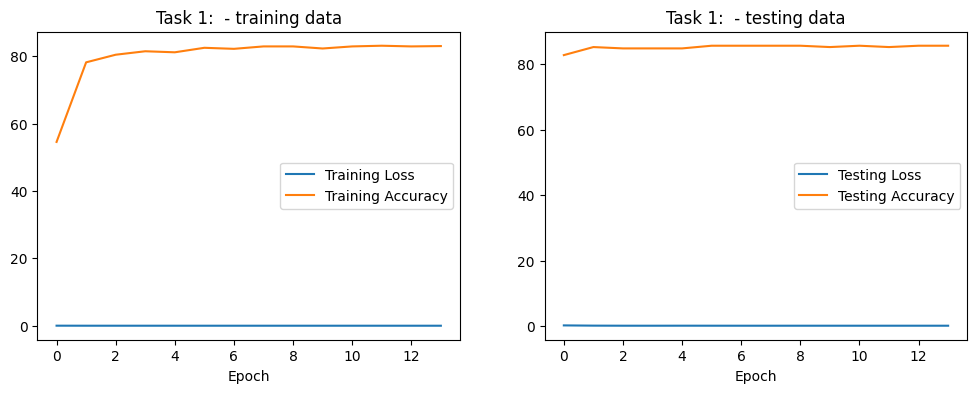

In [4]:
# Define task 1 labeling
task1_classes = [0, 1, 2, 3, 4, 9]
# Check the unique labels in your dataset to make sure they are integers
unique_labels = set(label for _, label in mnist_dataset)
print("Unique Labels in Dataset:", unique_labels)
# Make sure labels are integers; if not, convert them to integers
mnist_dataset = [(image, int(label)) for image, label in mnist_dataset]
task1_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in task1_classes]
task1_dataset = Subset(mnist_dataset, task1_indices)
print("Selected labels for Task 1:", set(label for _, label in task1_dataset))
train_size_task1 = int(0.8 * len(task1_indices))
test_size_task1 = len(task1_indices) - train_size_task1
train_loader_task1, test_loader_task1 = get_data_loaders(task1_dataset, train_size_task1, test_size_task1,
                                                             train_kwargs, test_kwargs)
model = models.Net_log_softmax(classes = 6).to(device)
# model = models.AlexNet(classes = 6).to(device)
# model = models.BaseModel(28 * 28, 100, 6).to(device)

optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
all_predictions, all_labels = train_and_test(args, model, device, train_loader_task1, test_loader_task1, optimizer, scheduler,title="Task 1: ")
model_state_dict_task1 = model.state_dict()
save_model_state_dict(model_state_dict_task1, "mnist_cnn_task1.pt")

### Testing 
Additionally, we store the predictions and losses

In [5]:
test_accuracy, test_loss, all_predictions, all_labels  = test(model, device, test_loader_task1)


Test set: Average loss: 0.1033, Accuracy: 209/244 (86%)



In [6]:
all_predictions

array([4, 4, 0, 3, 3, 1, 4, 1, 4, 1, 3, 1, 2, 1, 4, 3, 3, 3, 1, 0, 4, 4,
       0, 0, 2, 1, 4, 0, 2, 1, 3, 4, 1, 4, 2, 4, 0, 3, 0, 1, 3, 4, 1, 1,
       0, 0, 1, 3, 0, 3, 4, 1, 4, 2, 2, 1, 1, 2, 3, 0, 2, 1, 3, 2, 0, 3,
       1, 1, 4, 4, 3, 4, 1, 3, 3, 0, 1, 1, 3, 1, 0, 2, 2, 0, 1, 3, 0, 3,
       2, 1, 1, 2, 3, 4, 3, 3, 3, 4, 1, 4, 0, 4, 0, 0, 1, 2, 1, 3, 1, 4,
       4, 3, 2, 0, 2, 4, 0, 1, 4, 1, 0, 1, 0, 3, 3, 2, 2, 4, 1, 1, 3, 1,
       1, 4, 3, 1, 4, 3, 4, 0, 4, 1, 0, 0, 4, 2, 4, 3, 4, 0, 2, 4, 4, 1,
       3, 4, 3, 0, 4, 2, 3, 4, 1, 0, 1, 4, 3, 0, 1, 1, 2, 2, 1, 2, 2, 4,
       4, 2, 4, 3, 0, 4, 4, 4, 0, 4, 3, 4, 0, 2, 3, 0, 2, 2, 1, 3, 1, 1,
       4, 3, 1, 4, 4, 1, 1, 2, 0, 3, 4, 3, 1, 3, 1, 1, 4, 4, 1, 3, 4, 0,
       3, 3, 4, 4, 4, 3, 0, 1, 0, 0, 3, 1, 3, 1, 4, 1, 1, 4, 2, 3, 3, 1,
       3, 3])

In [7]:
np.unique(all_predictions), np.unique(all_labels)

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4, 9]))

In [8]:
all_predictions.shape, all_labels.shape

((244,), (244,))

In [9]:
unique_classes = np.unique(np.concatenate((all_labels, all_predictions)))
unique_classes

array([0, 1, 2, 3, 4, 9])

In [10]:
confusion_mat = confusion_matrix(all_labels, all_predictions, labels=unique_classes)
conf_matrix = pd.DataFrame(confusion_mat, index=unique_classes, columns=unique_classes)
conf_matrix

,0,1,2,3,4,9
0,38,0,0,1,0,0
1,0,58,0,0,1,0
2,0,0,30,1,0,0
3,0,2,1,49,0,0
4,0,0,0,0,34,0
9,1,1,0,3,24,0


In [11]:
confusion_mat.shape

(6, 6)

Customize your confusion matrix https://seaborn.pydata.org/generated/seaborn.heatmap.html 

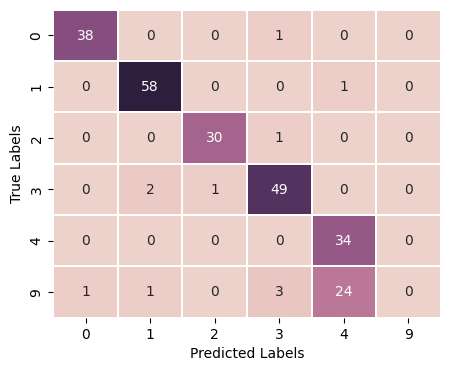

In [12]:
import seaborn as sns

unique_classes = np.unique(np.concatenate((all_labels, all_predictions)))
confusion_mat = confusion_matrix(all_labels, all_predictions, labels=unique_classes)
conf_matrix = pd.DataFrame(confusion_mat, index=unique_classes, columns=unique_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
ax = sns.heatmap(conf_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.1, cbar=False)

# Set labels and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Set x and y ticks using the unique classes
ax.set_xticks(range(len(unique_classes)))
ax.set_yticks(range(len(unique_classes)))

# Set x and y ticks at the center of the cells
ax.set_xticks([i + 0.5 for i in range(len(unique_classes))])
ax.set_yticks([i + 0.5 for i in range(len(unique_classes))])


plt.show()


In [13]:
np.unique(all_predictions)

array([0, 1, 2, 3, 4])

In [14]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=[str(c) for c in task1_classes]))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        39
           1       0.95      0.98      0.97        59
           2       0.97      0.97      0.97        31
           3       0.91      0.94      0.92        52
           4       0.58      1.00      0.73        34
           9       0.00      0.00      0.00        29

    accuracy                           0.86       244
   macro avg       0.73      0.81      0.76       244
weighted avg       0.78      0.86      0.81       244



/Users/sebasmos/opt/anaconda3/envs/book/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sebasmos/opt/anaconda3/envs/book/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sebasmos/opt/anaconda3/envs/book/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

## Training on second task

Selected labels for Task 2: {0, 5, 6, 7, 8, 9}
-------------------MODEL TRAINING TASK #2-------------------
Train Epoch: 1 [0/938 (0%)]	Loss: 2.271125
Train Epoch: 1 [640/938 (67%)]	Loss: 0.015446

Test set: Average loss: 0.0199, Accuracy: 71/235 (30%)

Epoch 1/14: Training Loss: 0.0041, Test Accuracy: 30.21%
Train Epoch: 2 [0/938 (0%)]	Loss: 0.034529
Train Epoch: 2 [640/938 (67%)]	Loss: 0.083685

Test set: Average loss: 0.0108, Accuracy: 72/235 (31%)

Epoch 2/14: Training Loss: 0.0005, Test Accuracy: 30.64%
Train Epoch: 3 [0/938 (0%)]	Loss: 0.007272
Train Epoch: 3 [640/938 (67%)]	Loss: 0.014336

Test set: Average loss: 0.0088, Accuracy: 72/235 (31%)

Epoch 3/14: Training Loss: 0.0002, Test Accuracy: 30.64%
Train Epoch: 4 [0/938 (0%)]	Loss: 0.003617
Train Epoch: 4 [640/938 (67%)]	Loss: 0.005266

Test set: Average loss: 0.0063, Accuracy: 72/235 (31%)

Epoch 4/14: Training Loss: 0.0002, Test Accuracy: 30.64%
Train Epoch: 5 [0/938 (0%)]	Loss: 0.004657
Train Epoch: 5 [640/938 (67%)]	Loss: 

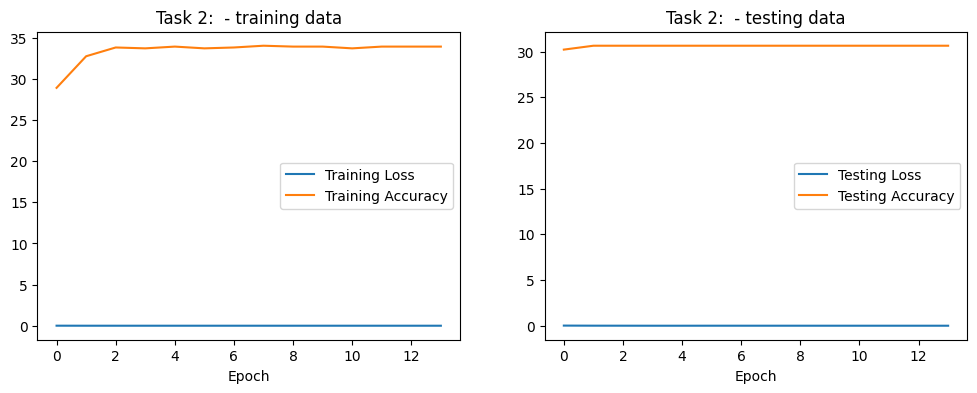

In [15]:
# Define task 2 labeling
task2_classes = [5, 6, 7, 8, 9, 0]
task2_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in task2_classes]
task2_dataset = Subset(mnist_dataset, task2_indices)
print("Selected labels for Task 2:", set(label for _, label in task2_dataset))
train_size_task2 = int(0.8 * len(task2_indices))
test_size_task2 = len(task2_indices) - train_size_task2

model_task2 = models.Net_log_softmax(classes = 6).to(device)
# model_task2 = models.BaseModel(28 * 28, 100, 6).to(device)
# model_task2 = models.AlexNet(classes = 6).to(device)
model_task2.load_state_dict(model_state_dict_task1.copy()) 
optimizer_task2 = optim.Adadelta(model_task2.parameters(), lr=args.lr)
# optimizer_task2 = optim.Adadelta(model.parameters(), lr=1)
# scheduler_task2 = StepLR(optimizer_task2, step_size=1, gamma=0.7)
scheduler_task2 = StepLR(optimizer_task2, step_size=1, gamma=args.gamma)

print(f"MODEL TRAINING TASK #2".center(60, "-"))

train_loader_task2, test_loader_task2 = get_data_loaders(task2_dataset, train_size_task2, test_size_task2,
                                                             train_kwargs, test_kwargs)

train_and_test(args, model_task2, device, train_loader_task2, test_loader_task2, optimizer_task2, scheduler_task2, title="Task 2: ")

model_state_dict_task2 = model_task2.state_dict()
save_model_state_dict(model_state_dict_task1, "mnist_cnn_task2.pt")




Test set: Average loss: 0.0064, Accuracy: 72/235 (31%)



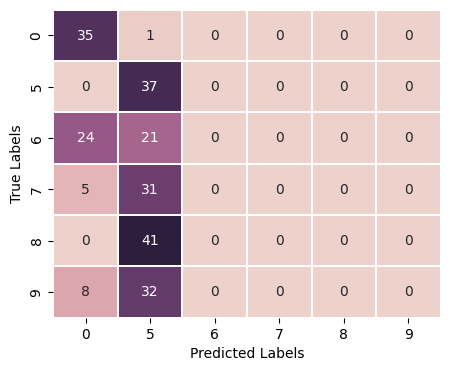

(array([0, 5]), array([0, 5, 6, 7, 8, 9]))

In [16]:
test_accuracy, test_loss, all_predictions, all_labels = test(model_task2, device, test_loader_task2)
unique_classes = np.unique(np.concatenate((all_labels, all_predictions)))
confusion_mat = confusion_matrix(all_labels, all_predictions, labels=unique_classes)
conf_matrix = pd.DataFrame(confusion_mat, index=unique_classes, columns=unique_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
ax = sns.heatmap(conf_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.1, cbar=False)

# Set labels and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Set x and y ticks using the unique classes
ax.set_xticks(range(len(unique_classes)))
ax.set_yticks(range(len(unique_classes)))

# Set x and y ticks at the center of the cells
ax.set_xticks([i + 0.5 for i in range(len(unique_classes))])
ax.set_yticks([i + 0.5 for i in range(len(unique_classes))])


plt.show()
np.unique(all_predictions), np.unique(all_labels)

In [17]:
unique_classes

array([0, 5, 6, 7, 8, 9])

In [18]:
np.unique(all_predictions), np.unique(all_labels)

(array([0, 5]), array([0, 5, 6, 7, 8, 9]))

Test it over task-2 data 

In [19]:
test_accuracy, test_loss, all_predictions, all_labels  = test(model_task2, device, test_loader_task2)


Test set: Average loss: 0.0064, Accuracy: 72/235 (31%)



## Testing model again on task 1


In [20]:
test_accuracy, test_loss, all_predictions, all_labels  = test(model_task2, device, test_loader_task1)


Test set: Average loss: 3.3407, Accuracy: 67/244 (27%)



In [21]:
# model_task1_adapted = models.Net_log_softmax(classes=6).to(device)
# model_state_dict_task2 = torch.load("models/mnist_cnn_task2.pt")
# model_task1_adapted.load_state_dict(model_state_dict_task2.copy()) 
# test_accuracy, test_loss, all_predictions, all_labels  = test(model_task1_adapted, device, test_loader_task1)

In [26]:
np.unique(all_predictions), np.unique(all_labels)

(array([0, 1, 2, 4, 5]), array([0, 1, 2, 3, 4, 9]))


Test set: Average loss: 3.3407, Accuracy: 67/244 (27%)



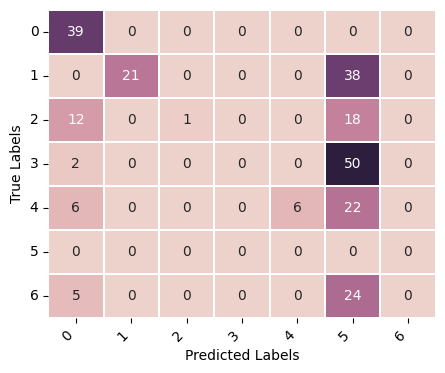

In [23]:
test_accuracy, test_loss, all_predictions, all_labels = test(model_task2, device,  test_loader_task1)
confusion_mat = confusion_matrix(all_labels, all_predictions )
conf_matrix = pd.DataFrame(confusion_mat)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
ax = sns.heatmap(conf_matrix,annot=True,  cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.1, cbar=False)

# Set labels and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticklabels(range(confusion_mat.shape[0]), rotation=45, ha='right')
ax.set_yticklabels(range(confusion_mat.shape[0]), rotation=0)

# Display the plot
plt.show()

In [28]:
# print("\nClassification Report:")
# print(classification_report(all_labels, all_predictions, target_names=[str(c) for c in task1_classes]))